# Rescheduling mit Tardiness (Summe)
> Rescheduling des Tages 1

In [1]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
import src.utils.presenter as show
from src.utils.analize import check_constrains as check
from src.utils.production_process import initialize as init
from src.utils.production_process import filter as process_filter
from src.utils.production_process import gen_deadline as gen_deadline

# Solver Model
from src.models.lp import tardiness_scheduling as lp_tard_schedule
from src.models.lp import tardiness_rescheduling as lp_tard_reschedule
import src.models.heuristics.fcfs as fcfs

# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation

# Extern
import pandas as pd
pd.set_option('display.max_rows', 16)

In [2]:
max_time = 60 * 5

In [3]:
day_count = 1

basic_data_path = get_path("data", "basic")
df_routings = pd.read_csv(basic_data_path / "instance.csv")

df_jssp, df_jobs_arrivals = init.create_jobs_for_shifts(df_routings = df_routings,
                                                        routing_column = "Routing_ID", job_column = "Job",
                                                        shift_count = 1, shift_length = 1440,
                                                        u_b_mmax = 0.94, shuffle = True,
                                                        job_seed=40, arrival_seed=80
                                                       )
df_jobs_times = gen_deadline.get_times_df(df_jssp, df_jobs_arrivals, fcfs.schedule_with_arrivals, target_service=1.0)
df_jobs_times


Schedule-Informationen:
  Makespan: 2319


,Job,Routing_ID,Arrival,Ready Time,Deadline
0,J0,9,49,1440,1109.0
1,J1,5,130,1440,1104.0
2,J2,3,151,1440,1437.0
3,J3,4,226,1440,998.0
4,J4,6,386,1440,1203.0
...,...,...,...,...,...
15,J15,5,1142,1440,2116.0
16,J16,6,1254,1440,2071.0
17,J17,7,1285,1440,2343.0
18,J18,8,1397,1440,2569.0


## I) Complete Scheduling

In [4]:
# Scheduling
df_schedule = lp_tard_schedule.solve_jssp_sum(df_jssp, df_jobs_times, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.01)
df_schedule


Solver-Informationen:
  Summe Tardiness         : 0.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 2140
  Anzahl Constraints      : 4020
  Laufzeit                : ~203 Sekunden


,Job,Operation,Machine,Processing Time,Routing_ID,Arrival,Ready Time,Deadline,Start,End,Tardiness
0,J0,0,M01,85,9,49,1440,1109.0,49.0,134.0,0.0
1,J0,1,M00,13,9,49,1440,1109.0,227.0,240.0,0.0
2,J0,2,M02,61,9,49,1440,1109.0,240.0,301.0,0.0
3,J0,3,M06,7,9,49,1440,1109.0,301.0,308.0,0.0
4,J0,4,M08,64,9,49,1440,1109.0,308.0,372.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
195,J9,5,M06,88,7,535,1440,1593.0,1239.0,1327.0,0.0
196,J9,6,M08,19,7,535,1440,1593.0,1327.0,1346.0,0.0
197,J9,7,M09,48,7,535,1440,1593.0,1346.0,1394.0,0.0
198,J9,8,M07,36,7,535,1440,1593.0,1394.0,1430.0,0.0


In [5]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Tardiness'))

label
0            20
0 - 60        0
60 - 120      0
120 - 180     0
>180          0
Name: count, dtype: int64


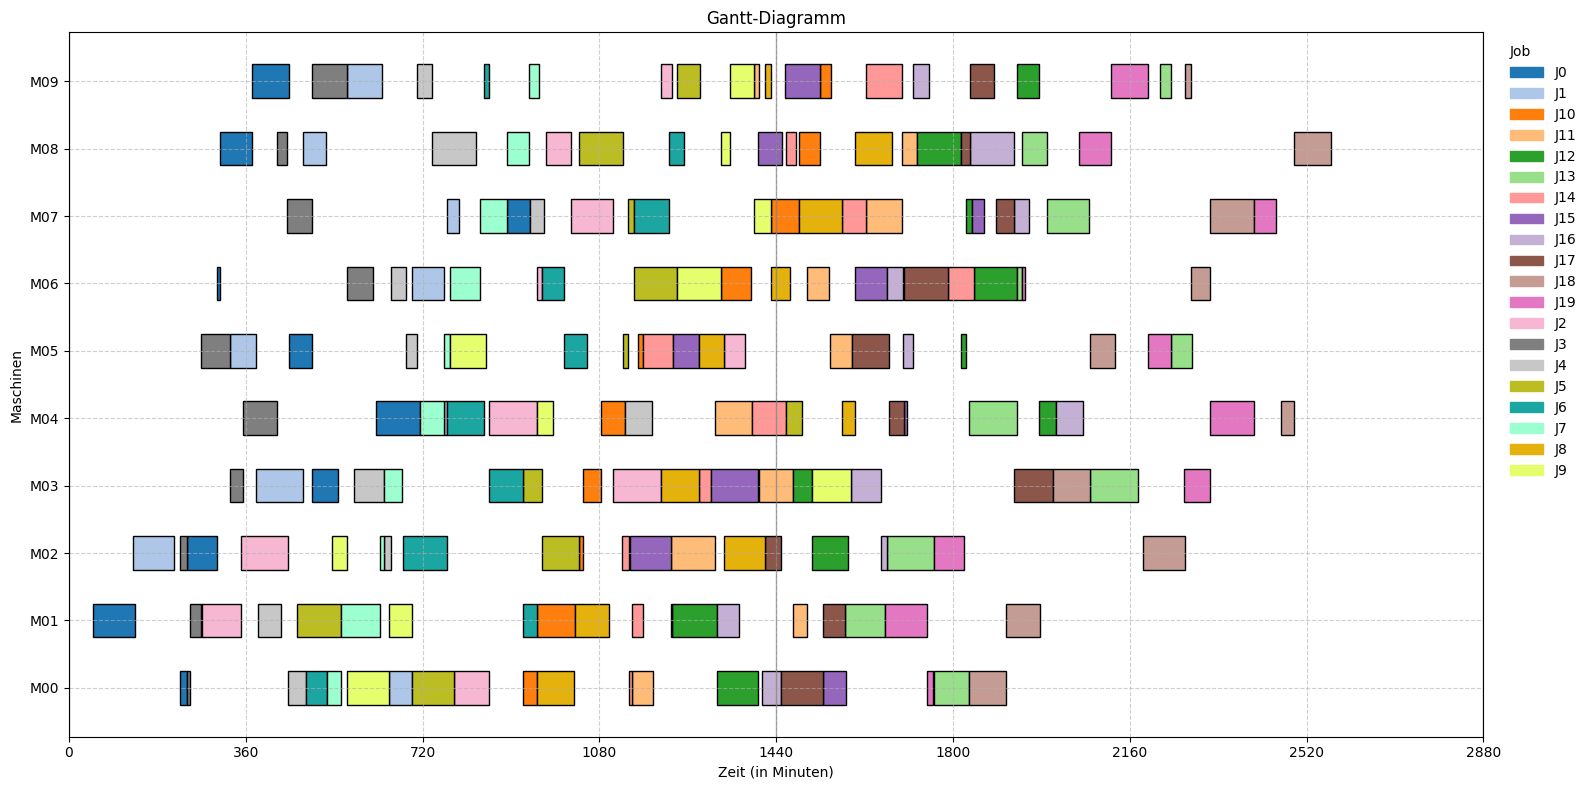

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [6]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

## II) Erster Tag (Tag 0)

### a) Simulation

In [7]:
day_length = 1440

In [8]:
day_numb = 0

day_start = day_length*day_numb 
day_end = day_start + day_length

In [9]:
simulation = ProductionSimulation(df_schedule, sigma=0.25)
df_execution = simulation.run(start_time = day_start, end_time=day_end)

[Day 0 00:49:00] Job J0 started on M01
[Day 0 02:10:00] Job J1 started on M02
[Day 0 02:19:41] Job J0 finished on M01 (after 90 minutes 42 seconds)
[Day 0 03:38:51] Job J1 finished on M02 (after 88 minutes 52 seconds)
[Day 0 03:46:00] Job J3 started on M02
[Day 0 03:47:00] Job J0 started on M00
[Day 0 03:57:25] Job J0 finished on M00 (after 10 minutes 25 seconds)
[Day 0 04:04:40] Job J3 finished on M02 (after 18 minutes 40 seconds)
[Day 0 04:04:40] Job J0 started on M02
[Day 0 04:04:40] Job J3 started on M00
[Day 0 04:10:43] Job J3 finished on M00 (after 06 minutes 04 seconds)
[Day 0 04:10:43] Job J3 started on M01
[Day 0 04:29:56] Job J3 finished on M01 (after 19 minutes 13 seconds)
[Day 0 04:29:56] Job J1 started on M01
[Day 0 04:29:56] Job J3 started on M05
[Day 0 04:32:48] Job J1 finished on M01 (after 02 minutes 52 seconds)
[Day 0 04:32:48] Job J2 started on M01
[Day 0 04:50:16] Job J0 finished on M02 (after 45 minutes 36 seconds)
[Day 0 05:01:00] Job J0 started on M06
[Day 0 05:0

In [10]:
df_plan_undone = process_filter.get_unexecuted_operations(df_schedule, df_execution)
df_plan_undone 

,Job,Operation,Machine,Processing Time,Routing_ID,Arrival,Ready Time,Deadline,Start,End,Tardiness
0,J10,7,M07,56,0,922,1440,1697.0,1430.0,1486.0,0.0
1,J10,8,M08,44,0,922,1440,1697.0,1486.0,1530.0,0.0
2,J10,9,M09,21,0,922,1440,1697.0,1530.0,1551.0,0.0
3,J11,4,M03,69,1,928,1440,1929.0,1405.0,1474.0,0.0
4,J11,5,M01,28,1,928,1440,1929.0,1474.0,1502.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
78,J8,6,M06,40,8,526,1440,1698.0,1429.0,1469.0,0.0
79,J8,7,M07,89,8,526,1440,1698.0,1486.0,1575.0,0.0
80,J8,8,M04,26,8,526,1440,1698.0,1575.0,1601.0,0.0
81,J8,9,M08,74,8,526,1440,1698.0,1601.0,1675.0,0.0


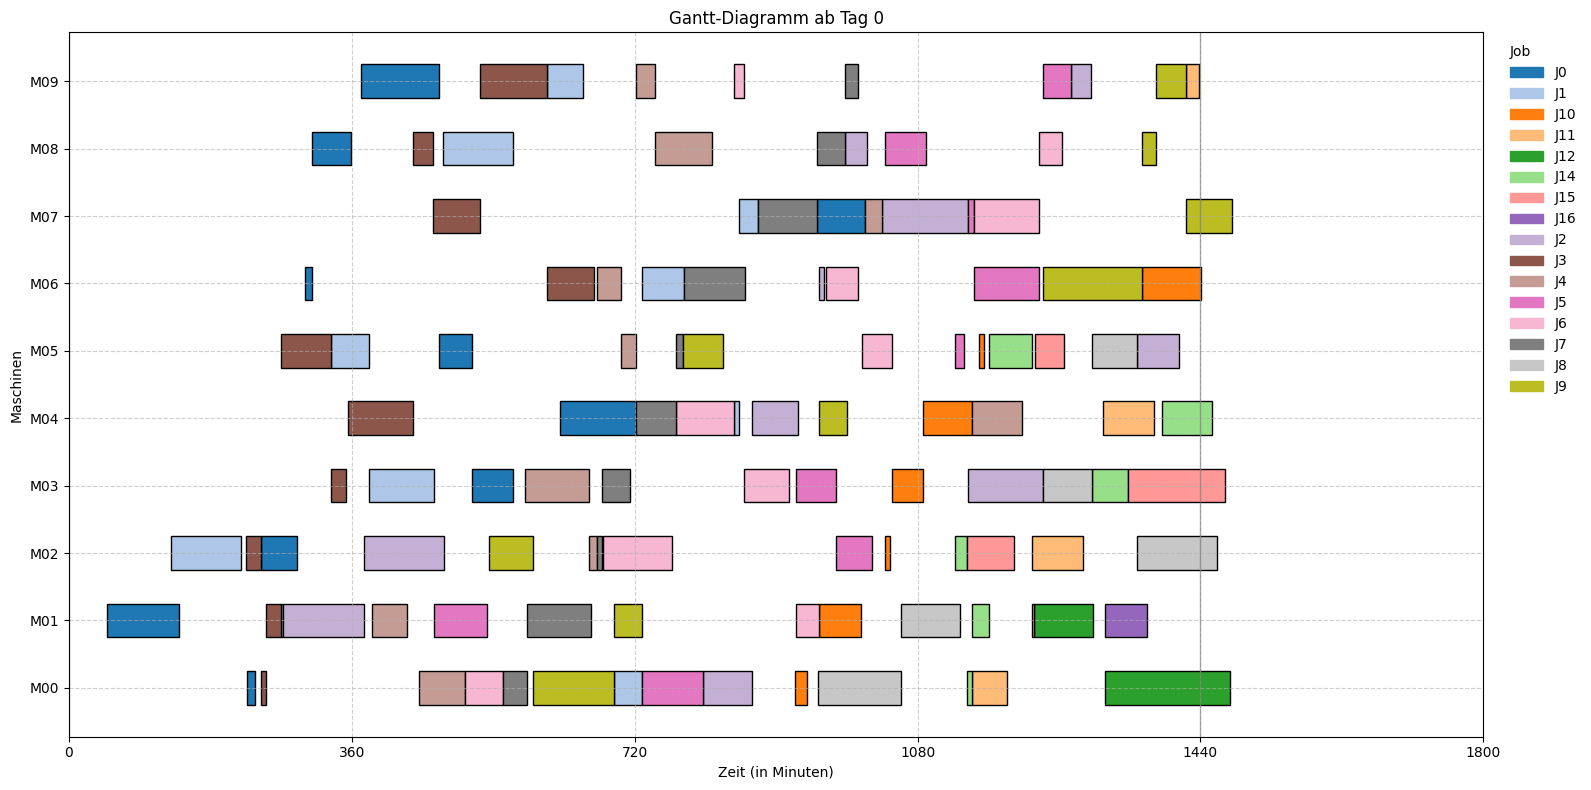

In [11]:
if not df_execution.empty:
    show.plot_gantt(df_execution, perspective="Machine", title=f"Gantt-Diagramm ab Tag {day_numb}")
else:
    print(f"Nothing executed on day {day_numb}")

### b) Verbleibene Jobs (Rest)

In [12]:
df_plan_undone 

,Job,Operation,Machine,Processing Time,Routing_ID,Arrival,Ready Time,Deadline,Start,End,Tardiness
0,J10,7,M07,56,0,922,1440,1697.0,1430.0,1486.0,0.0
1,J10,8,M08,44,0,922,1440,1697.0,1486.0,1530.0,0.0
2,J10,9,M09,21,0,922,1440,1697.0,1530.0,1551.0,0.0
3,J11,4,M03,69,1,928,1440,1929.0,1405.0,1474.0,0.0
4,J11,5,M01,28,1,928,1440,1929.0,1474.0,1502.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
78,J8,6,M06,40,8,526,1440,1698.0,1429.0,1469.0,0.0
79,J8,7,M07,89,8,526,1440,1698.0,1486.0,1575.0,0.0
80,J8,8,M04,26,8,526,1440,1698.0,1575.0,1601.0,0.0
81,J8,9,M08,74,8,526,1440,1698.0,1601.0,1675.0,0.0


In [13]:
df_job_times_undone = process_filter.update_times_after_operation_changes(df_jobs_times, df_plan_undone)
df_job_times_undone

,Job,Routing_ID,Arrival,Ready Time,Deadline
0,J5,2,464,1440,1579.0
1,J8,8,526,1440,1698.0
2,J9,7,535,1440,1593.0
3,J10,0,922,1440,1697.0
4,J11,1,928,1440,1929.0
5,J12,2,950,1440,2065.0
6,J13,3,1001,1440,2287.0
7,J14,4,1127,1440,1899.0
8,J15,5,1142,1440,2116.0
9,J16,6,1254,1440,2071.0


## III) Rescheduling
> vereinfacht, ohne neu Aufträge (nur der Rest)

In [14]:
# Reduktion der bereits ausgeführten Operationen auf die relevanten für die nächsten Tage
df_execution_important = df_execution[df_execution["End"] >= 1440]
df_execution_important

,Job,Routing_ID,Operation,Machine,Arrival,Start,Processing Time,End
26,J10,0,6,M06,922,1365.79,75.03,1440.82
32,J12,2,1,M00,950,1319.00,158.71,1477.71
38,J14,4,5,M04,1127,1391.00,63.39,1454.39
42,J15,5,3,M03,1142,1347.90,123.27,1471.17
107,J8,8,4,M02,526,1359.65,101.71,1461.36
116,J9,7,8,M07,535,1422.11,58.16,1480.27


In [15]:
df_reschedule = lp_tard_reschedule.solve_jssp_sum_with_fixed_ops(df_plan_undone, df_job_times_undone,
                                                                 df_execution_important,
                                                                 reschedule_start = 1440,
                                                                 solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.0)
df_reschedule

BigM: 3000

Solver-Informationen:
  Summe Tardiness         : 30.54
  Solver-Status           : Optimal
  Anzahl Variablen        : 484
  Anzahl Constraints      : 859
  Laufzeit                : ~11 Sekunden


,Job,Operation,Machine,Processing Time,Routing_ID,Arrival,Ready Time,Deadline,Start,End,Tardiness
0,J10,7,M07,56,0,922,1440,1697.0,1480.27,1536.27,0.00
1,J10,8,M08,44,0,922,1440,1697.0,1536.27,1580.27,0.00
2,J10,9,M09,21,0,922,1440,1697.0,1591.17,1612.17,0.00
3,J11,4,M03,69,1,928,1440,1929.0,1559.27,1628.27,0.00
4,J11,5,M01,28,1,928,1440,1929.0,1628.27,1656.27,0.00
...,...,...,...,...,...,...,...,...,...,...,...
78,J8,6,M06,40,8,526,1440,1698.0,1472.36,1512.36,0.00
79,J8,7,M07,89,8,526,1440,1698.0,1536.27,1625.27,0.00
80,J8,8,M04,26,8,526,1440,1698.0,1625.27,1651.27,0.00
81,J8,9,M08,74,8,526,1440,1698.0,1651.27,1725.27,27.27


In [16]:
last_ops = df_reschedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Tardiness'))

label
0            11
0 - 60        2
60 - 120      0
120 - 180     0
>180          0
Name: count, dtype: int64


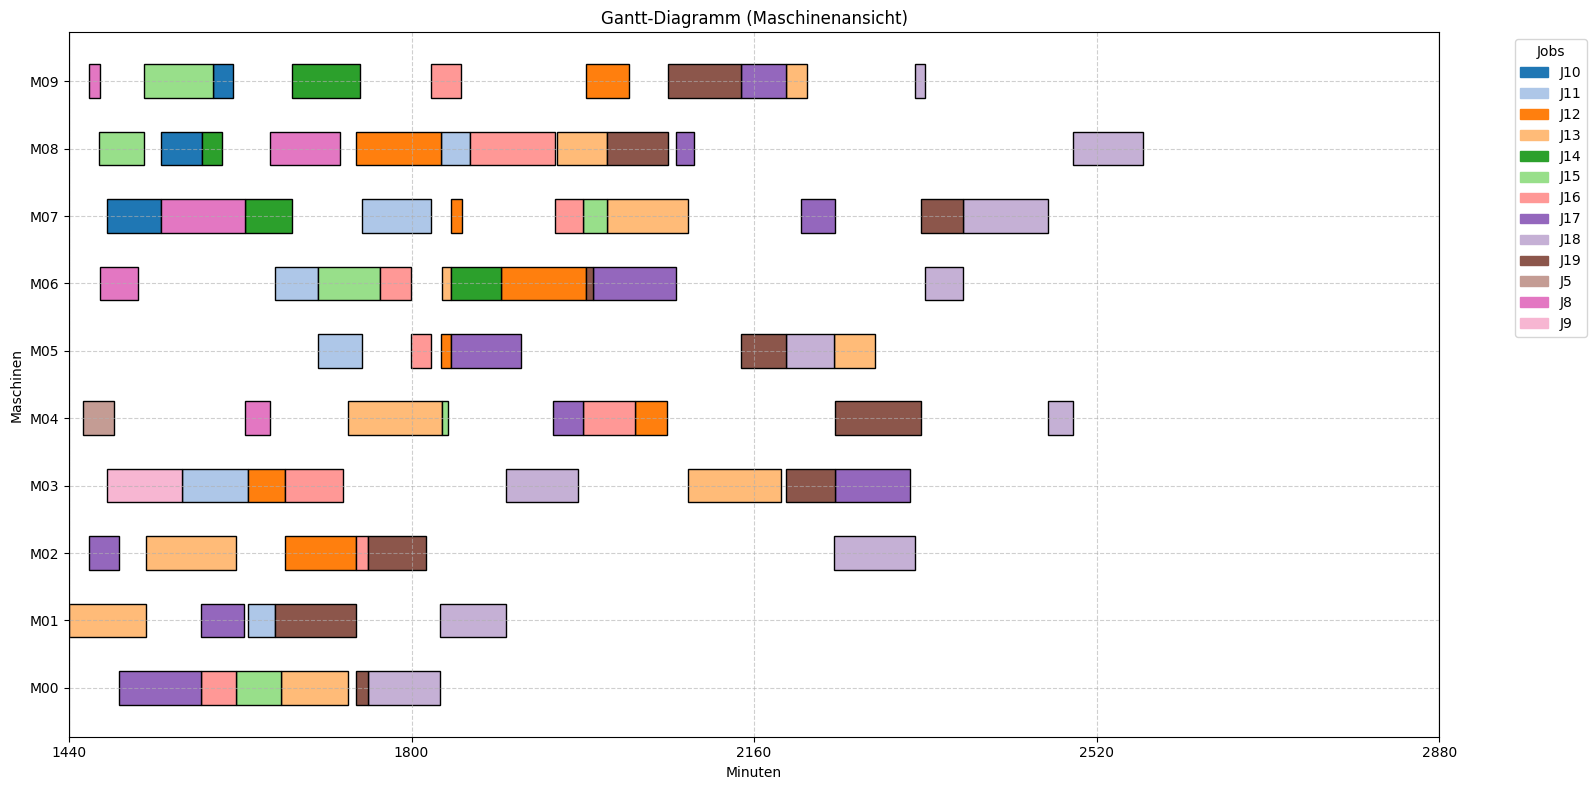

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [17]:
show.plot_gantt_machines(df_reschedule)
check.is_machine_conflict_free(df_reschedule)
check.is_operation_sequence_correct(df_reschedule)
check.is_job_timing_correct(df_reschedule)
check.is_start_correct(df_reschedule)

## Simulation + neuer Schedule 

In [18]:
df_combined = pd.concat([df_execution, df_reschedule], ignore_index=True)
df_combined

,Job,Routing_ID,Operation,Machine,Arrival,Start,Processing Time,End,Ready Time,Deadline,Tardiness
0,J0,9,0,M01,49,49.00,90.70,139.70,NaN,NaN,NaN
1,J0,9,1,M00,49,227.00,10.42,237.42,NaN,NaN,NaN
2,J0,9,2,M02,49,244.67,45.60,290.27,NaN,NaN,NaN
3,J0,9,3,M06,49,301.00,8.52,309.52,NaN,NaN,NaN
4,J0,9,4,M08,49,309.52,49.94,359.46,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
195,J8,8,6,M06,526,1472.36,40.00,1512.36,1440.0,1698.0,0.00
196,J8,8,7,M07,526,1536.27,89.00,1625.27,1440.0,1698.0,0.00
197,J8,8,8,M04,526,1625.27,26.00,1651.27,1440.0,1698.0,0.00
198,J8,8,9,M08,526,1651.27,74.00,1725.27,1440.0,1698.0,27.27


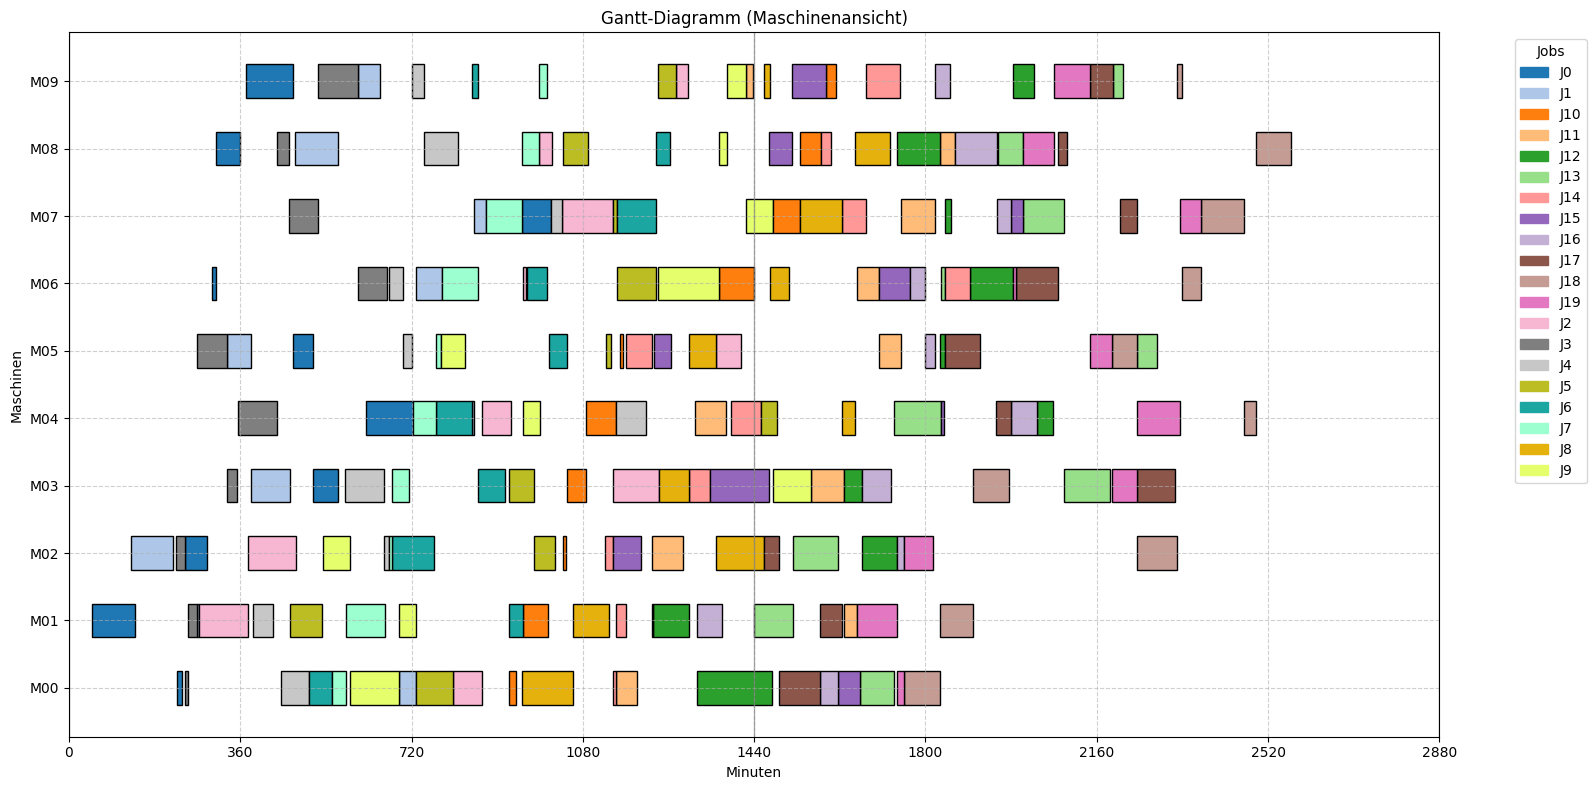

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [19]:
df = df_combined
show.plot_gantt_machines(df)
check.is_machine_conflict_free(df)
check.is_operation_sequence_correct(df)
check.is_job_timing_correct(df)
check.is_start_correct(df)